In [1]:
from __future__ import print_function

import os
import math
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, variance

# CARGA DE DATOS

In [3]:
# Parseamos el fichero del modelo y devolvemos una lista con los scores
def GetScores(path):
  with open(path) as file:
    lines = file.readlines()
    filtered_lines = np.asarray([])
    for line in lines:
      # usamos solo el valor de score sin los \n
      line = line.split(" ")[1]
      line = line.split("\n")[0]
      filtered_lines = np.insert(filtered_lines,0,float(line))
    return np.array(filtered_lines)

In [4]:
path_clientsA = "scoresA_clientes"
path_impostorsA = "scoresA_impostores"
path_clientsB = "scoresB_clientes"
path_impostorsB = "scoresB_impostores"

clientsA = GetScores(path_clientsA)
impostorsA = GetScores(path_impostorsA)
clientsB = GetScores(path_clientsB)
impostorsB = GetScores(path_impostorsB)

# IMPLEMENTACIÓN

In [5]:
def DataSummary(clients, impostors):
  print("CLIENTS")
  print(clients.shape)
  print([min(clientsA),max(clientsA)])
  print("IMPOSTORS")
  print(impostors.shape)
  print([min(impostorsA),max(impostorsA)])

def GetFPFN(scores, thr):
  FP = 0
  FN = 0
  for i in range(len(scores)):
    if (scores[i,0] > thr) & (scores[i,1] == 'i'):
      FP += 1
    if (scores[i,0] <= thr) & (scores[i,1] == 'c'):
      FN += 1
  return FP, FN

def GetRatios(clients, impostors):
  num_clients = len(clients)
  num_impostors = len(impostors)
  # Ordered list of labeled scores
  labeled_clients = np.array([(score,'c') for score in clients])
  labeled_impostors = np.array([(score,'i') for score in impostors])  
  scores = np.concatenate((labeled_clients, labeled_impostors))
  scores = scores[scores[:,0].argsort()]
  # List of thresholds
  thresholds = np.unique(scores[:,0])
  # List of FNR and FPR for each threshold
  FPRs = np.array([])
  FNRs = np.array([])
  for thr in thresholds:
    FP, FN = GetFPFN(scores, thr)
    FPRs = np.append(FPRs, FP/num_impostors)
    FNRs = np.append(FNRs, FN/num_clients)
  return scores, thresholds, FPRs, FNRs

In [6]:
def PlotRoc(FPRs, FNRs, show_dots=False):
  x = np.concatenate(([1], FPRs, [0]))
  y = np.concatenate(([1], 1-FNRs, [0]))
  if show_dots:
    plt.plot(x, y, 'ro', markerfacecolor='none')
  else:
    plt.plot(x, y)
  plt.plot([0,1], [0,1], color="green", linestyle="--")
  plt.xlim(0.0, 1.0)
  plt.ylim(0.0, 1.0)
  plt.xlabel('FP')
  plt.ylabel('1-FN') 
  plt.show()

In [7]:
def FPwhenFN(FPRs, FNRs, fnr, optimistic=True):
  # FP(FN=x) FPR for the thresold where FNR is closest to x (optimism as parameter)
  idx = -1
  idxs = np.where(FNRs == fnr)[0]
  if len(idxs) == 0:
    # Find closest
    diff = -1
    for i in range(len(FNRs)):
      if diff < 0 or abs(FNRs[i] - fnr) < diff:
        diff = abs(FNRs[i] - fnr)
        idx = i
  elif len(idxs) == 1:
    # Only one match
    idx = idxs[0]
  elif len(idxs) > 1:
    # Multiple matches, consider optimism
    if optimistic:
      idx = np.max(idxs) # Lower FP
    else:
      idx = np.min(idxs)
  return idx

def FNwhenFP(FPRs, FNRs, fpr, optimistic=True):
  # FN(FP=x) FNR for the thresold where FPR is closest to x (optimism as parameter)
  idx = -1
  idxs = np.where(FPRs == fpr)[0]
  if len(idxs) == 0:
    # Find closest
    diff = -1
    for i in range(len(FPRs)):
      if diff < 0 or abs(FPRs[i] - fpr) < diff:
        diff = abs(FPRs[i] - fpr)
        idx = i
  elif len(idxs) == 1:
    # Only one match
    idx = idxs[0]
  elif len(idxs) > 1:
    # Multiple matches, consider optimism
    if optimistic:
      idx = np.max(idxs) # Lower FP 
    else:
      idx = np.min(idxs)
  return idx

def FPeqFN(FPRs, FNRs, optimistic = True):
  # FP=FN threshold that minimizes diff between FPR and FNR
  idx = -1
  idxs = np.where(FPRs == FNRs)[0]
  if len(idxs) == 0:
    # Find closest
    diff = -1
    for i in range(len(FPRs)):
      if diff < 0 or abs(FPRs[i] - FNRs[i]) < diff:
        diff = abs(FPRs[i] - FNRs[i])
        idx = i
  elif len(idxs) == 1:
    # Only one match
    idx = idxs[0]
  elif len(idxs) > 1:
    # Multiple matches, consider optimism
    if optimistic:
      idx = max(idxs) # Lower FP 
    else:
      idx = min(idxs)
  return idx

In [8]:
def DPrime(clients, impostors):
  avg_c = mean(clients)
  avg_i = mean(impostors)
  var_c = variance(clients)
  var_i = variance(impostors)
  return (avg_c - avg_i) / math.sqrt(var_c + var_i)

In [9]:
def H(sc, si):
  if sc > si:
    return 1
  elif sc == si:
    return 0.5
  else:
    return 0

def AUC(clients, impostors):
  return (1/(len(clients)*len(impostors)))*(sum([sum([H(c,i) for i in impostors]) for c in clients]))

# PRUEBAS - MODELO A

CLIENTS
(1430,)
[0.000743, 1.0]
IMPOSTORS
(1560,)
[0.0, 0.252618]


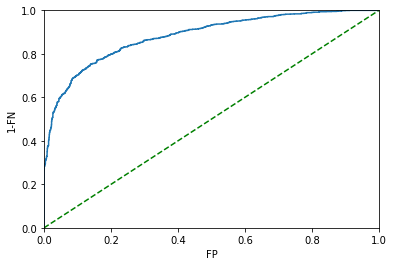

FP(FN=0.2): At threshold 0.050144, FN=0.2 and FP=0.2032051282051282
FN(FP=0.2): At threshold 0.050524, FN=0.2020979020979021 and FP=0.2
FP=FN: At threshold 0.050333, FPR=0.2012820512820513 and FNR=0.2013986013986014 (Diff=0.0001165501165501237)
D-prime: 0.7596882641658939
AUC: 0.8831634391249776


In [10]:
clients = clientsA
impostors = impostorsA

DataSummary(clients,impostors)
scores, thresholds, FPRs, FNRs = GetRatios(clients, impostors)

PlotRoc(FPRs, FNRs, show_dots=False)

idx = FPwhenFN(FPRs, FNRs, 0.2, optimistic = True)
print(f"FP(FN=0.2): At threshold {thresholds[idx]}, FN={FNRs[idx]} and FP={FPRs[idx]}")

idx = FNwhenFP(FPRs, FNRs, 0.2, optimistic = True)
print(f"FN(FP=0.2): At threshold {thresholds[idx]}, FN={FNRs[idx]} and FP={FPRs[idx]}")

idx = FPeqFN(FPRs, FNRs, optimistic = True)
print(f"FP=FN: At threshold {thresholds[idx]}, FPR={FPRs[idx]} and FNR={FNRs[idx]} (Diff={abs(FPRs[idx]-FNRs[idx])})")

print(f"D-prime: {DPrime(clients, impostors)}")
print(f"AUC: {AUC(clients, impostors)}")

# PRUEBAS - MODELO B

CLIENTS
(1430,)
[0.000743, 1.0]
IMPOSTORS
(1560,)
[0.0, 0.252618]


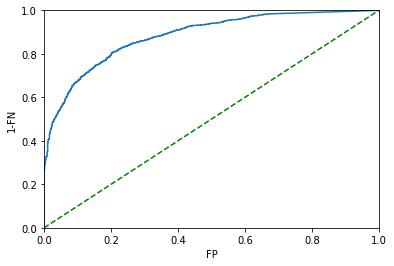

FP(FN=0.2): At threshold 0.04431, FN=0.2 and FP=0.2012820512820513
FN(FP=0.2): At threshold 0.045244, FN=0.2055944055944056 and FP=0.2
FP=FN: At threshold 0.044359, FPR=0.2012820512820513 and FNR=0.2006993006993007 (Diff=0.0005827505827505908)
D-prime: 0.8731771850825502
AUC: 0.8830825264479111


In [11]:
clients = clientsB
impostors = impostorsB

DataSummary(clients,impostors)
scores, thresholds, FPRs, FNRs = GetRatios(clients, impostors)

PlotRoc(FPRs, FNRs, show_dots=False)

idx = FPwhenFN(FPRs, FNRs, 0.2, optimistic = True)
print(f"FP(FN=0.2): At threshold {thresholds[idx]}, FN={FNRs[idx]} and FP={FPRs[idx]}")

idx = FNwhenFP(FPRs, FNRs, 0.2, optimistic = True)
print(f"FN(FP=0.2): At threshold {thresholds[idx]}, FN={FNRs[idx]} and FP={FPRs[idx]}")

idx = FPeqFN(FPRs, FNRs, optimistic = True)
print(f"FP=FN: At threshold {thresholds[idx]}, FPR={FPRs[idx]} and FNR={FNRs[idx]} (Diff={abs(FPRs[idx]-FNRs[idx])})")

print(f"D-prime: {DPrime(clients, impostors)}")
print(f"AUC: {AUC(clients, impostors)}")